In [1]:
%load_ext autoreload
import numpy as np
import seaborn as sns
import os
import ClassificationModelsimplerev1 as ClassificationModelsimple
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

2023-03-09 21:44:02.881975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 21:44:03.724211: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 21:44:04.208394: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-09 21:44:08.007391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
def trainmodel(model,train_ds,val_ds):
    
    NUMBER_EPOCHS = 100
    filepath='TrainedWeights/checkptRev1randval'
    BATCH_SIZE=32
    
    model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_auc",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
        options=None
    )
    print(type(train_ds))
    hist = model.fit(train_ds,
                     epochs=NUMBER_EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=val_ds,
                    #  validation_split=0.2,#auto validate using 20% of random samples at each epoch
                     verbose=1, callbacks=[model_checkpoint_callback],class_weight = {0: 1, 1: 5}

                    )
    return hist


In [8]:
#Spatial cross validation

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('Landslide')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def spatialCrossVal():
    for i in range(1,11):
        print(i)
        all_inputs = []
        encoded_features = []
        
        train_df=df[df.id!=i]
        test_df=df[df.id==i]
        print(f"Number of train set{len(train_df)} and number of test set {len(test_df)}")
 
        exai_ds=df_to_dataset(train_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']])
        val_ds=df_to_dataset(test_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']],shuffle=False)
        y_test=test_df['Landslide'].to_numpy()
        

        for header in numerical_cols:
          numeric_col = tf.keras.Input(shape=(1,), name=header)
          normalization_layer = get_normalization_layer(header, exai_ds)
          encoded_numeric_col = normalization_layer(numeric_col)
          all_inputs.append(numeric_col)
          encoded_features.append(encoded_numeric_col)

        for header in categorical_cols:
          categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
          encoding_layer = get_category_encoding_layer(name=header,
                                                      dataset=exai_ds,
                                                      dtype='string',
                                                      max_tokens=9)
          encoded_categorical_col = encoding_layer(categorical_col)
          all_inputs.append(categorical_col)
          encoded_features.append(encoded_categorical_col)

        clfmdl=ClassificationModelsimple.LandslideModel()
        clfmdl.getclassificationModel(all_inputs=all_inputs, encoded_features=encoded_features)
        clfmdl.getOptimizer()
        clfmdl.compileModel()

        trainmodel(clfmdl.model,exai_ds,val_ds)
        preds=clfmdl.model.predict(val_ds)
        np.save(f'crossval_results/SpPredsrv1_{str(i)}.npy',preds)
        np.save(f'crossval_results/SpTruthsrv1_{str(i)}.npy',y_test)
        del clfmdl
        i+=1
def randomCrossVal(dfc):
  kf = KFold(n_splits=10,random_state=42,shuffle=True)
  kf.get_n_splits(df)
  i=0
  for train_index, test_index in kf.split(df):
    print(i)
    all_inputs = []
    encoded_features = []
    
    #    df.iloc[train_index]
    # df.iloc[test_index]
    train_df=dfc.iloc[train_index]
    test_df=dfc.iloc[test_index]
    print(f"Number of train set{len(train_df)} and number of test set {len(test_df)}")

    exai_ds=df_to_dataset(train_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']])
    val_ds=df_to_dataset(test_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']],shuffle=False)
    y_test=test_df['Landslide'].to_numpy()
    

    for header in numerical_cols:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, exai_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)

    for header in categorical_cols:
      categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
      encoding_layer = get_category_encoding_layer(name=header,
                                                  dataset=exai_ds,
                                                  dtype='string',
                                                  max_tokens=9)
      encoded_categorical_col = encoding_layer(categorical_col)
      all_inputs.append(categorical_col)
      encoded_features.append(encoded_categorical_col)

    clfmdl=ClassificationModelsimple.LandslideModel()
    clfmdl.getclassificationModel(all_inputs=all_inputs, encoded_features=encoded_features)
    clfmdl.getOptimizer()
    clfmdl.compileModel()

    trainmodel(clfmdl.model,exai_ds,val_ds)
    preds=clfmdl.model.predict(val_ds)
    np.save(f'crossval_results/RvPredsrv1_{str(i)}.npy',preds)
    np.save(f'crossval_results/RvTruthsrv1_{str(i)}.npy',y_test)
    del clfmdl
    i+=1
    # del clfmdl

In [ ]:
categorical_cols = ['GLG']
numerical_cols=['Est_m', 'Nrt_m', 'HC_m', 'VC_m', 'Slp_m', 'Prc_m', 'NDVI_m', 'PGV_Usgs', 'Sand_m', 'Silt_m', 'Clay_m', 'Bdod_m']
df=gpd.read_file('Data/NepalEqUSGSV4.shp')
spatialCrossVal()

In [ ]:
categorical_cols = ['GLG']
numerical_cols=['Est_m', 'Nrt_m', 'HC_m', 'VC_m', 'Slp_m', 'Prc_m', 'NDVI_m', 'PGV_Usgs', 'Sand_m', 'Silt_m', 'Clay_m', 'Bdod_m']
df=gpd.read_file('Data/NepalEqUSGSV4.shp')
randomCrossVal(df)

# Cross validation plots

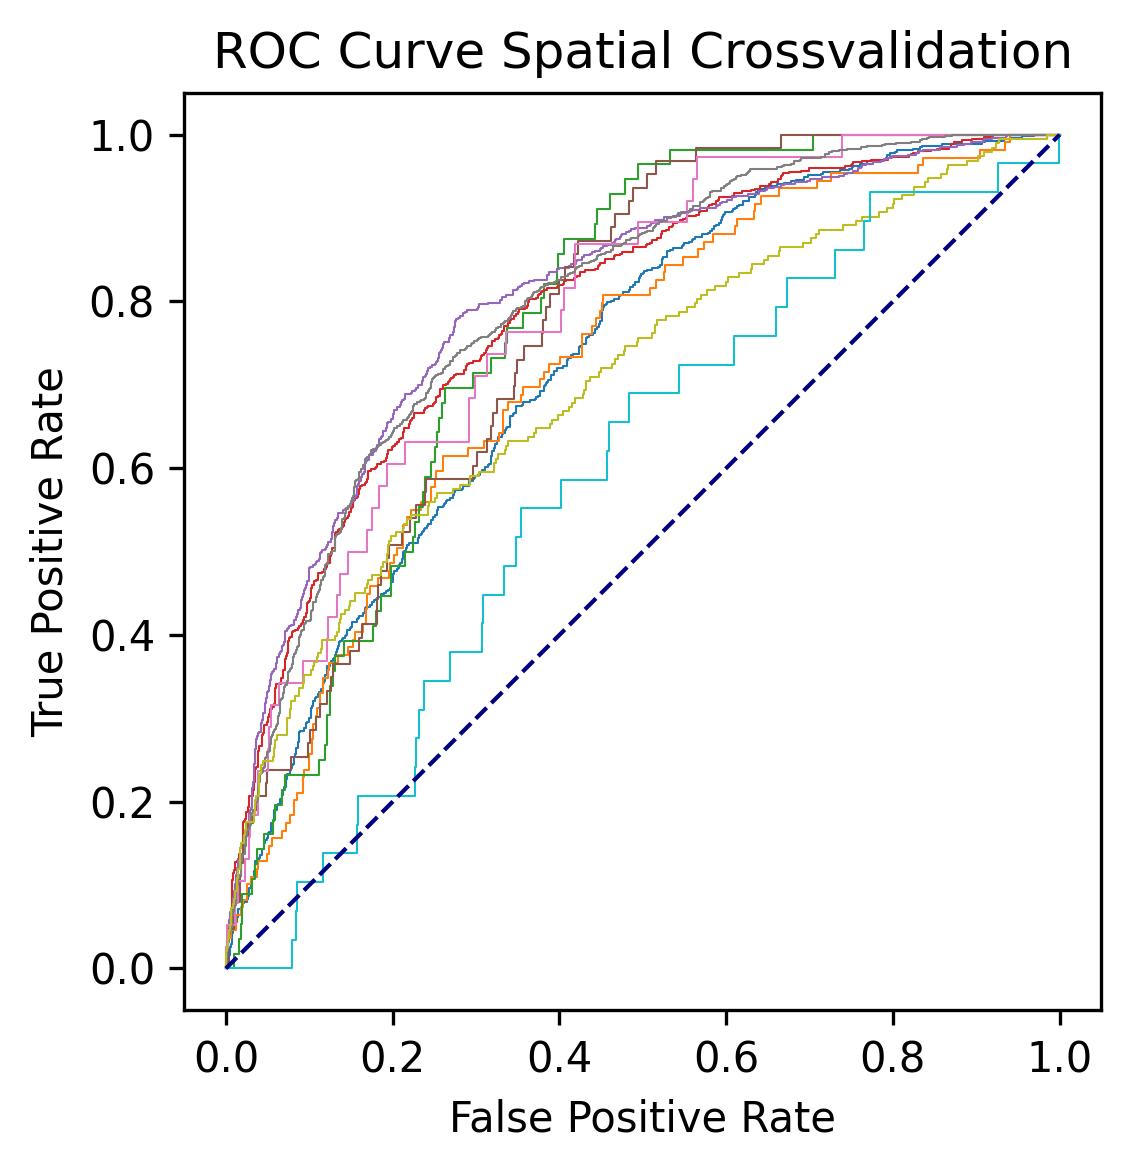

In [2]:
#plot 
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np 
figure(figsize=(4, 4), dpi=300)
Aucs=[]
for i in range(1,11):
    preds=np.load(f'crossval_results/SpPredsrv1_{str(i)}.npy')
    truths=np.load(f'crossval_results/SpTruthsrv1_{str(i)}.npy')
    fpr,tpr,thresholds=sklearn.metrics.roc_curve(truths.flatten(), preds.flatten())
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=0.5,
        label=f"ValArea{str(i)}",
    )
    Aucs.append(sklearn.metrics.auc(fpr,tpr))

ax=plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Spatial Crossvalidation")
# plt.text(0.38, 0.11,"Accuracy=0.8131")
# plt.legend(loc="lower right")
plt.axis('square')
plt.tight_layout()
plt.savefig('Exaiplots/rocSpValrev1.pdf')
plt.show()


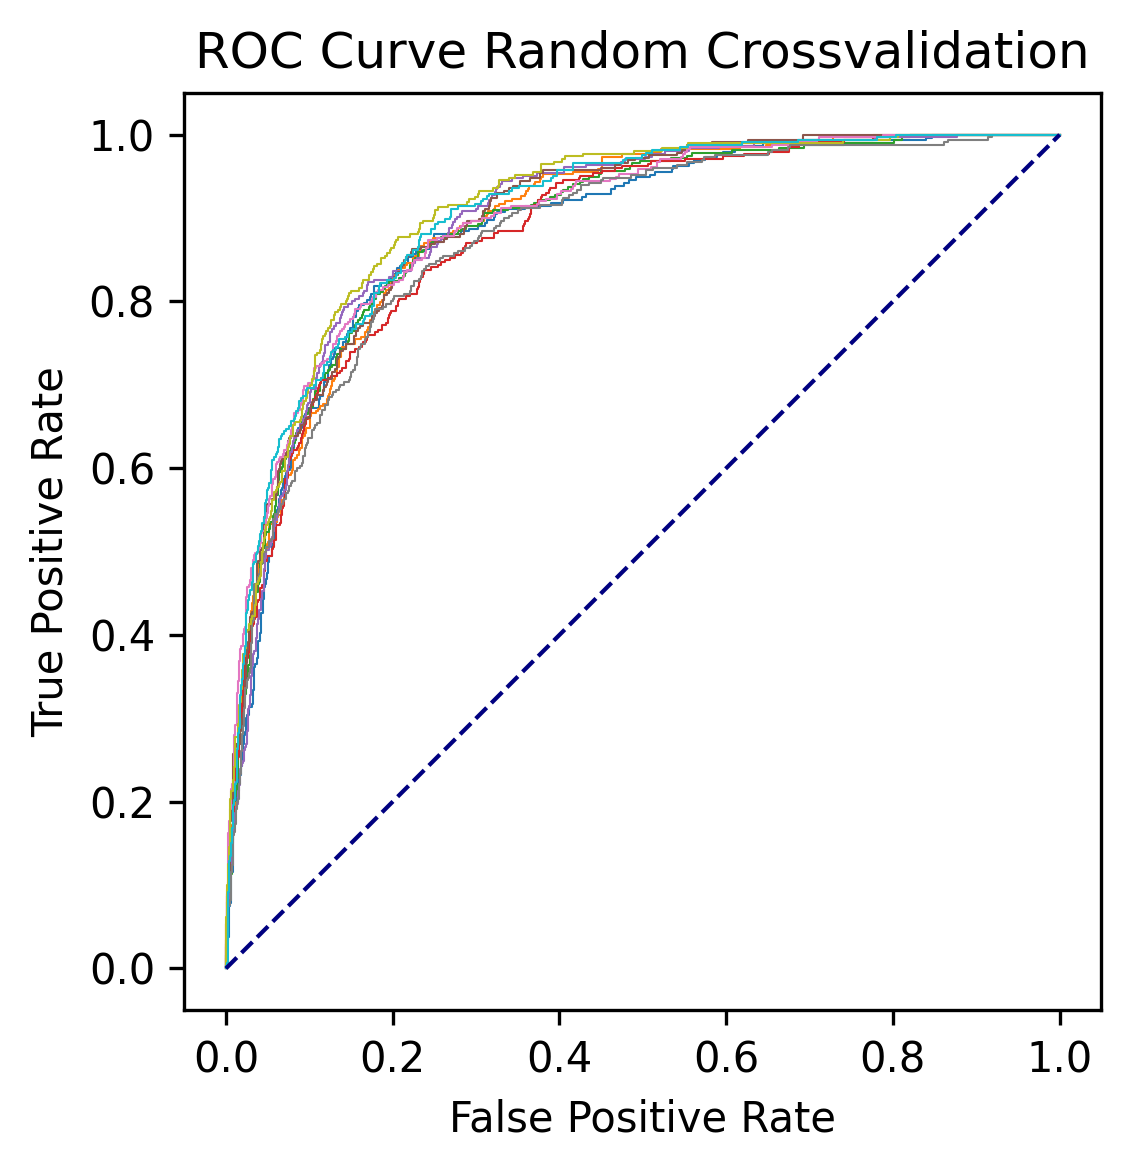

In [3]:
#plot 
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np 
figure(figsize=(4, 4), dpi=300)
Aucs2=[]
for i in range(0,10):
    preds=np.load(f'crossval_results/RvPredsrv1_{str(i)}.npy')
    truths=np.load(f'crossval_results/RvTruthsrv1_{str(i)}.npy')
    fpr,tpr,thresholds=sklearn.metrics.roc_curve(truths.flatten(), preds.flatten())
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=0.5,
        label=f"RandomArea{str(i+1)}",
    )
    Aucs2.append(sklearn.metrics.auc(fpr,tpr))

ax=plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Random Crossvalidation")
# plt.text(0.38, 0.11,"Accuracy=0.8131")
# plt.legend(loc="lower right")
plt.axis('square')
plt.tight_layout()
plt.savefig('Exaiplots/rocrandValrv1.pdf')
plt.show()


In [16]:
Aucs2

[0.8846185674556704,
 0.8929987770004137,
 0.8898031066182944,
 0.8818544873977826,
 0.8964026852167144,
 0.8971522271576238,
 0.8967618970649641,
 0.877250967727158,
 0.908349146110057,
 0.9022519544523604]

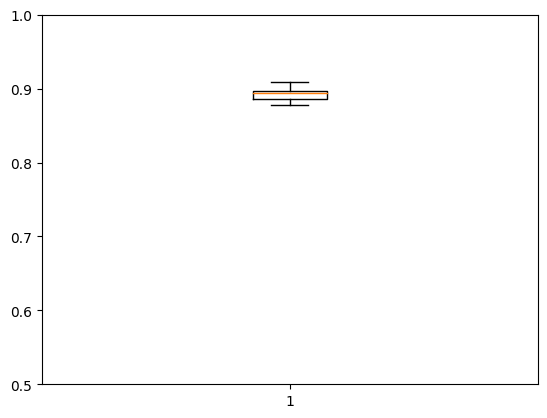

In [4]:

plt.boxplot(Aucs2)
plt.ylim(0.5,1)
plt.savefig('Exaiplots/violin_randomvalrv1.pdf')


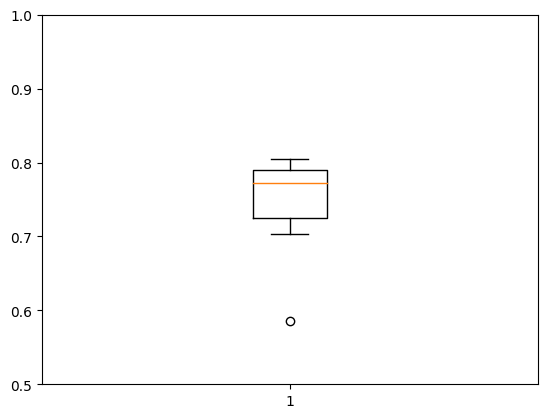

In [5]:
plt.boxplot(Aucs)
plt.ylim(0.5,1)
plt.savefig('Exaiplots/violin_spvalrv1.pdf')

In [ ]:
# plot all confusion maps


In [6]:
#plot 
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np 
rcl_indexes=[]
df=gpd.read_file('Data/NepalEqUSGSV4.shp')
kf = KFold(n_splits=10,random_state=42,shuffle=True)
kf.get_n_splits(df)
i=0
for train_index, test_index in kf.split(df):
    rcl_indexes.append(test_index)

for i in range(0,10):
    print(i)
    preds=np.load(f'crossval_results/RvPredsrv1_{str(i)}.npy')
    truths=np.load(f'crossval_results/RvTruthsrv1_{str(i)}.npy')

    #confusion  map
    confusiondata=np.empty(truths.shape,dtype=object)
    confusiondata[np.bitwise_and(truths.flatten()==1,np.rint(preds.flatten())==1)]='True Positive'
    confusiondata[np.bitwise_and(truths.flatten()==0,np.rint(preds.flatten())==1)]='False Positive'
    confusiondata[np.bitwise_and(truths.flatten()==1,np.rint(preds.flatten())==0)]='False Negative'
    confusiondata[np.bitwise_and(truths.flatten()==0,np.rint(preds.flatten())==0)]='True Negative'
    sel_idx=rcl_indexes[i].tolist()
    df.loc[sel_idx,'rcl_confusion']=confusiondata
df_rc=df

0
1
2
3
4
5
6
7
8
9


In [7]:
df=gpd.read_file('Data/NepalEqUSGSV4.shp')
for i in range(1,11):
    preds=np.load(f'crossval_results/SpPredsrv1_{str(i)}.npy')
    truths=np.load(f'crossval_results/SpTruthsrv1_{str(i)}.npy')
    print(i)
    #confusion  map
    confusiondata=np.empty(truths.shape,dtype=object)
    confusiondata[np.bitwise_and(truths.flatten()==1,np.rint(preds.flatten())==1)]='True Positive'
    confusiondata[np.bitwise_and(truths.flatten()==0,np.rint(preds.flatten())==1)]='False Positive'
    confusiondata[np.bitwise_and(truths.flatten()==1,np.rint(preds.flatten())==0)]='False Negative'
    confusiondata[np.bitwise_and(truths.flatten()==0,np.rint(preds.flatten())==0)]='True Negative'
    sel_idx=df.index[df['id']==i].tolist()
    df.loc[sel_idx,'scl_confusion']=confusiondata
df_sc=df

1
2
3
4
5
6
7
8
9
10


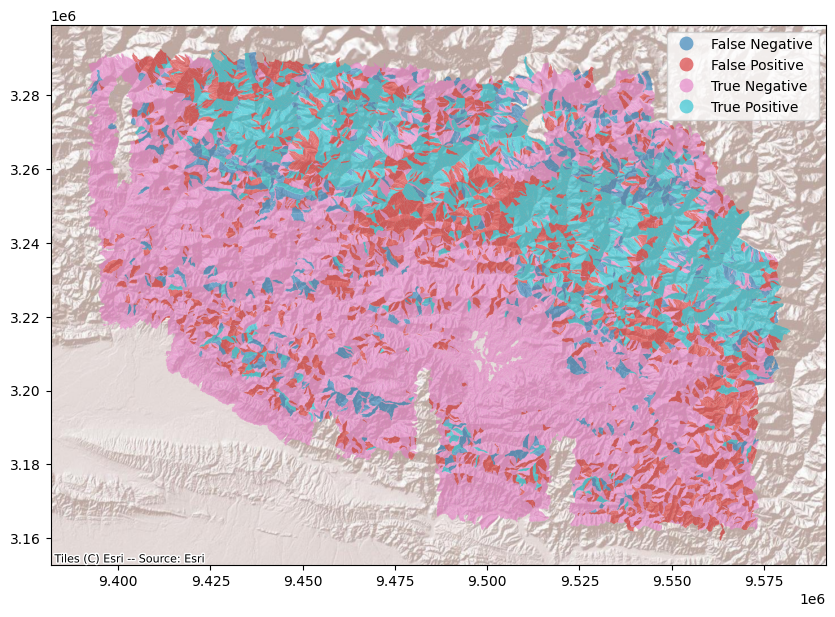

In [8]:
import contextily as cx
df_wm = df_sc.to_crs(epsg=3857)
ax=df_wm.plot(column='scl_confusion',legend=True,figsize=(10, 10), alpha=0.6,linewidth=0)
cx.add_basemap(ax,source=cx.providers.Esri.WorldShadedRelief)

In [9]:
ax.get_figure().savefig('Exaiplots/confusionmap_scvrv1.pdf',dpi=500,facecolor=ax.get_facecolor())

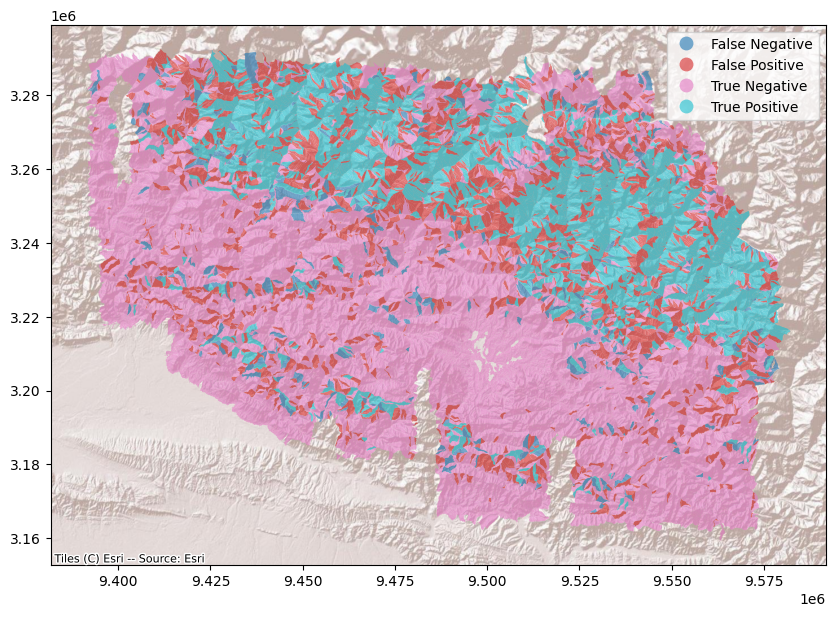

In [10]:
import contextily as cx
df_wm = df_rc.to_crs(epsg=3857)
ax=df_wm.plot(column='rcl_confusion',legend=True,figsize=(10, 10), alpha=0.6,linewidth=0)
cx.add_basemap(ax,source=cx.providers.Esri.WorldShadedRelief)

In [11]:
ax.get_figure().savefig('Exaiplots/confusionmap_rcvrv1.pdf',dpi=500,facecolor=ax.get_facecolor())

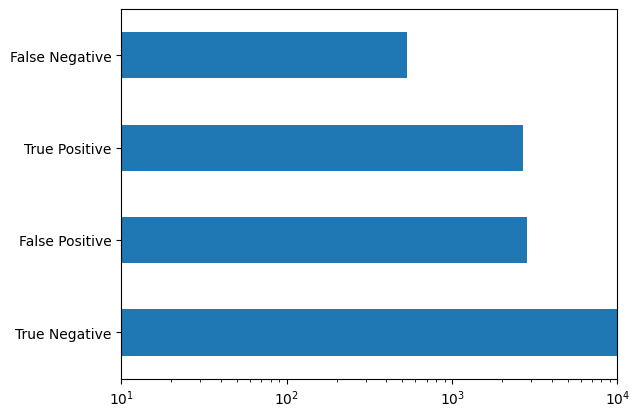

In [12]:
ax=df_rc.rcl_confusion.value_counts().plot(kind='barh',logx=True,xlim=(10,1e4))
ax.get_figure().savefig('Exaiplots/barplot_rcvrv1.pdf',dpi=500,facecolor=ax.get_facecolor())

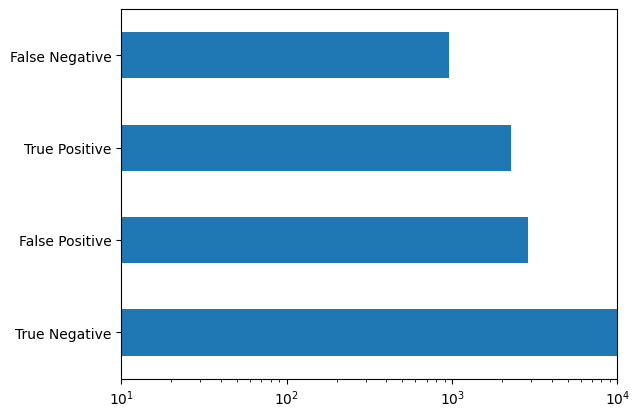

In [13]:
ax=df_sc.scl_confusion.value_counts().plot(kind='barh',logx=True,xlim=(10,1e4))
ax.get_figure().savefig('Exaiplots/barplot_scvrv1.pdf',dpi=500,facecolor=ax.get_facecolor())